In [4]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_51691/3108163380.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Set1", len(categories))


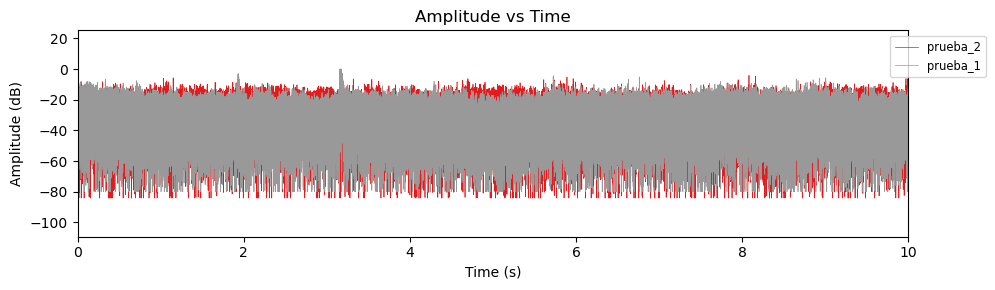

In [16]:
base_dir = "audio"

categories = [
    d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
]

plot_segment = True
segment = (0, 10)

plt.figure(figsize=(10, 3))
colors = plt.cm.get_cmap("Set1", len(categories))

for idx, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    for audio_file in audio_files:

        audio_path = os.path.join(folder_path, audio_file)
        y, sr = librosa.load(audio_path)

        if plot_segment:
            start_sample = int(segment[0] * sr)
            end_sample = int(segment[1] * sr)
            y = y[start_sample:end_sample]

        y_db = librosa.amplitude_to_db(np.abs(y))

        time = np.linspace(0, len(y) / sr, len(y))

        plt.plot(
            time,
            y_db,
            label=category if audio_file == audio_files[0] else "",
            color=colors(idx),
            linewidth=0.5,
        )

plt.title("Amplitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")

plt.margins(x=0, y=0.3)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1), fontsize="small")
plt.tight_layout()
plt.show()


/tmp/ipykernel_51691/943512783.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1', len(categories))  # Colores para cada categoría


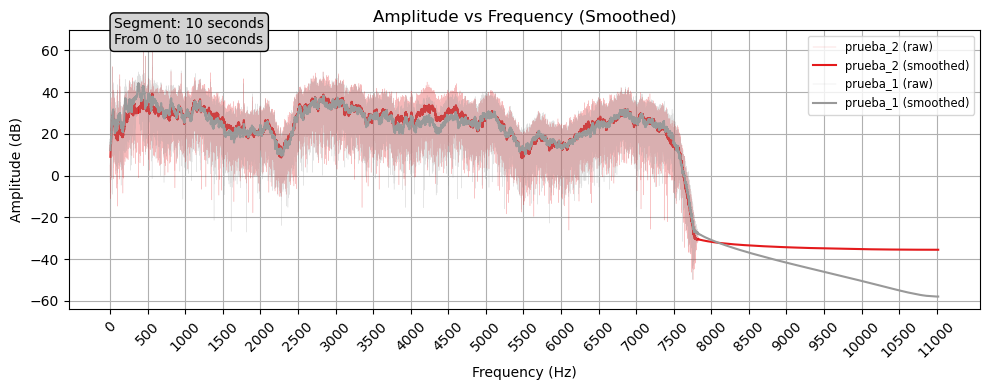

In [17]:
# Función para calcular el promedio móvil
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Parámetros para graficar Amplitud vs Frecuencia
plot_segment = True  # Cambiar a False si se quiere graficar todo el audio
segment = (0, 10)  # Segmento de inicio y fin en segundos (modificable)
window_size = 100  # Tamaño de la ventana para el suavizado

# Crear la figura donde se superpondrán las gráficas
plt.figure(figsize=(10, 4))
colors = plt.cm.get_cmap('Set1', len(categories))  # Colores para cada categoría

# Loop para procesar los audios y graficar Amplitud vs Frecuencia
for idx, category in enumerate(categories):  # 'categories' ya está definida en la celda anterior
    folder_path = os.path.join(base_dir, category)
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    for audio_file in audio_files:
        audio_path = os.path.join(folder_path, audio_file)
        y, sr = librosa.load(audio_path)

        # Si se seleccionó un segmento, extraer el segmento del audio
        if plot_segment:
            start_sample = int(segment[0] * sr)  # Convertir tiempo a muestras
            end_sample = int(segment[1] * sr)  # Convertir tiempo a muestras
            y = y[start_sample:end_sample]

        # Realizar la Transformada Rápida de Fourier (FFT)
        fft_result = np.fft.fft(y)

        # Obtener las frecuencias asociadas
        frequencies = np.fft.fftfreq(len(fft_result), 1 / sr)

        # Obtener la magnitud (amplitud) de la FFT
        magnitude = np.abs(fft_result)

        # Convertir la magnitud a decibeles (dB)
        magnitude_db = 20 * np.log10(magnitude + 1e-9)  # Añadir un pequeño valor para evitar log(0)

        # Filtrar solo la parte positiva de las frecuencias
        positive_frequencies = frequencies[:len(frequencies)//2]
        positive_magnitude_db = magnitude_db[:len(magnitude)//2]

        # Suavizado usando promedio móvil
        smoothed_magnitude_db = moving_average(positive_magnitude_db, window_size)
        smoothed_frequencies = moving_average(positive_frequencies, window_size)  # Ajustar frecuencias suavizadas

        # Graficar Amplitud vs Frecuencia original en dB
        plt.plot(positive_frequencies, positive_magnitude_db, 
                 label=f"{category} (raw)" if audio_file == audio_files[0] else "", 
                 color=colors(idx), linewidth=0.3, alpha=0.3)  # Graficar la señal original pero con transparencia

        # Graficar Amplitud vs Frecuencia suavizada
        plt.plot(smoothed_frequencies, smoothed_magnitude_db, 
                 label=f"{category} (smoothed)" if audio_file == audio_files[0] else "", 
                 color=colors(idx), linewidth=1.5)  # Graficar la envolvente suavizada

# Configuración de la gráfica
plt.title('Amplitude vs Frequency (Smoothed)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)

# Rotar las etiquetas del eje X para que sean más fáciles de leer
plt.xticks(rotation=45)

# Añadir más marcas en la escala de frecuencia del eje X
plt.xticks(np.arange(0, max(positive_frequencies), step=500))

# Añadir leyenda para diferenciar las categorías
plt.legend(loc="upper right", fontsize="small")

# Añadir anotación indicando los segundos que se están graficando
start_time = segment[0]  # Segundo de inicio
end_time = segment[1]    # Segundo de fin
plt.annotate(f'Segment: {end_time - start_time} seconds\nFrom {start_time} to {end_time} seconds', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))

# Ajustar el diseño para mejor visualización
plt.tight_layout()

# Mostrar la gráfica
plt.show()
